In [3]:
using Plots
import Pkg; Pkg.add("DataFrames")
using DataFrames
using Statistics
using Plots
import Pkg; Pkg.add("PlotlyJS")
using Pkg
Pkg.add("IJulia")
using Pkg
Pkg.add("GLM")
import Pkg; Pkg.add("PyPlot")



   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
Precompiling project...
  ✓ micromamba_jll
  ✓ MicroMamba
  ✓ CondaPkg
  ✓ PythonCall
  ✓ PythonPlot
  5 dependencies successfully precompiled in 12 seconds. 281 already precompiled.
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [4]:
function add_noise(value::Float64, noise_level::Float64)
    return value + (randn()*2-1) * noise_level
end

add_noise (generic function with 1 method)

In [5]:
function calc_MAE(v::Float64, v_hat::Float64)
    return mean(abs(v - v_hat))
end

calc_MAE (generic function with 1 method)

In [6]:
function calculate_sensitivity(real_velocities::Vector, measured_velocities::Vector)
    n = length(real_velocities)

    # Verifica se os tamanhos dos vetores são iguais
    if n != length(measured_velocities)
        error("Os vetores de velocidade real e medida precisam ter o mesmo tamanho.")
    end

    sensitivities = Float64[]

    for i in 2:n
        # Calcula as variações (diferenças) nas velocidades reais e medidas
        delta_real = real_velocities[i] - real_velocities[i-1]
        delta_measured = measured_velocities[i] - measured_velocities[i-1]
        println("Real Delta: $delta_real")
        println("Measured Delta: $delta_measured")
         println("Sense: $(delta_measured/delta_real)")
        # Calcula a sensibilidade e armazena
        if delta_real != 0
            push!(sensitivities, delta_measured / delta_real)
        end
    end

    return sensitivities
end

calculate_sensitivity (generic function with 1 method)

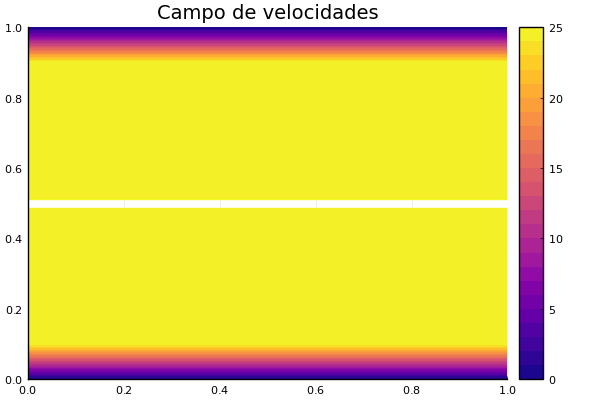

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [65]:
using LinearAlgebra
using Plots
pyplot()

N_POINTS = 11
KINEMATIC_VISCOSITY_5 = 1.8 *(10^(-6))
KINEMATIC_VISCOSITY_25 = 0.9 *(10^(-6))
KINEMATIC_VISCOSITY_55 = 0.5 *(10^(-6))
KINEMATIC_VISCOSITY_75 = 0.4 *(10^(-6))
KINEMATIC_VISCOSITY_100 = 0.3 *(10^(-6))

TIME_STEP_LENGTH = 0.1
N_TIME_STEPS = 200

PRESSURE_GRADIENT = [-0.3,0.0]
#PRESSURES= [-0.3,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39]
PRESSURES= [-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,-1.0,-1.1,-1.2]

N_PRESSURES = 10
N_VISCOSITIES = 5

element_length = sqrt(2) / (N_POINTS - 1)
x_range = range(0.0, stop=1.0, length=N_POINTS)
y_range = range(0.0, stop=1.0, length=N_POINTS)

coordinates_x = [x for x in x_range, y in y_range]
coordinates_y = [y for x in x_range, y in y_range]

function central_difference_x_periodic(field, element_length)
    diff = (circshift(field, (0, 1)) - circshift(field, (0, -1))) / (2 * element_length)
    return diff
end

function laplace_periodic(field, element_length)
    diff = (circshift(field, (0, 1)) + circshift(field, (1, 0)) +
            circshift(field, (0, -1)) + circshift(field, (-1, 0)) -
            4 * field) / element_length^2
    return diff
end

velocity_x_prev = ones(N_POINTS, N_POINTS)
velocity_x_prev[1, :] .= 0.0
velocity_x_prev[end, :] .= 0.0
velocity_x_final = copy(velocity_x_prev)

velocity_visc = []
velocity_pressure = []
VISCOSITIES = [KINEMATIC_VISCOSITY_5, KINEMATIC_VISCOSITY_25, KINEMATIC_VISCOSITY_55, KINEMATIC_VISCOSITY_75, KINEMATIC_VISCOSITY_100]


for i in 1:N_PRESSURES
#for i in 1:N_VISCOSITIES
    velocity_x_prev .= ones(N_POINTS, N_POINTS)
    velocity_x_prev[1, :] .= 0.0
    velocity_x_prev[end, :] .= 0.0
    
    for iter in 1:N_TIME_STEPS
        convection_x = velocity_x_prev .* central_difference_x_periodic(velocity_x_prev, element_length)
        diffusion_x = KINEMATIC_VISCOSITY_25 * laplace_periodic(velocity_x_prev, element_length)

        velocity_x_next = velocity_x_prev .+ TIME_STEP_LENGTH * (-PRESSURES[i] .+ diffusion_x .- convection_x)

        velocity_x_next[1, :] .= 0.0  
        velocity_x_next[end, :] .= 0.0 
        velocity_x_prev = velocity_x_next
    end
    #push!(velocity_visc, copy(velocity_x_prev))
    push!(velocity_pressure, copy(velocity_x_prev))
end

p5 = contourf(coordinates_y, coordinates_x, velocity_x_prev, levels=25, title="Campo de velocidades", color=:plasma)
plot(p5, layout=(1,1))

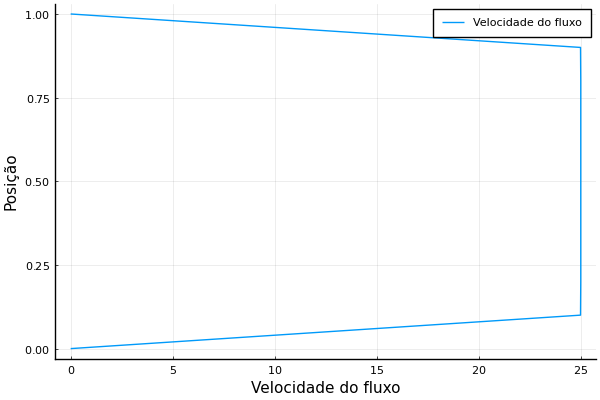

In [66]:
plot(velocity_x_prev[:, 2], y_range, label="Velocidade do fluxo", xlabel="Velocidade do fluxo", ylabel="Posição")

In [67]:
function transit_time_at_point_up(velocity, element_length, speed_of_sound)
    angle_factor = cos(π / 4)
    time = (element_length / (speed_of_sound - (velocity * angle_factor)))
    return time
end

function transit_time_at_point_down(velocity, element_length, speed_of_sound)
    angle_factor = cos(π / 4)
    time = (element_length / (speed_of_sound + (velocity * angle_factor)))
    return time
end

transit_time_at_point_down (generic function with 1 method)

In [68]:
using Random

# Adicionar um seed fixo para garantir que o ruído seja sempre o mesmo
Random.seed!(1234)  # Escolha qualquer número para o seed


delta_t_vec = []
calc = []
medio = []
for index in 1:N_PRESSURES
    beam_path = []
    row = 1
    col = 1
    
    while row >= 0 && row <= N_POINTS && col >= 0 && col <= N_POINTS
        push!(beam_path, copy(velocity_pressure[index][row, col]))
        row = row + 1
        col = col + 1
    end

    beam_times_down = []
    beam_times_up = []
    SPEED_OF_SOUND = 1450
    L = sqrt(2)
    element_length = L / (N_POINTS - 1)

    for i in 1:N_POINTS
        push!(beam_times_down, copy(transit_time_at_point_down(beam_path[i], element_length, SPEED_OF_SOUND)))
        push!(beam_times_up, copy(transit_time_at_point_up(beam_path[i], element_length, SPEED_OF_SOUND)))
    end

    total_transit_time_up = reduce(+, beam_times_up)
    total_transit_time_down = reduce(+, beam_times_down)
    #println("Total transit time up along the 45-degree path: $total_transit_time_up seconds")
    #println("Total transit time down along the 45-degree path: $total_transit_time_down seconds")

    # Aplicação do Modelo
    delta_t = total_transit_time_up - total_transit_time_down
    push!(delta_t_vec,copy(delta_t))
    product_t = total_transit_time_up * total_transit_time_down
    v_calculated = (L * delta_t) / (2 * cos(π / 4) * product_t)
    # Adição de ruído com seed fixo
    v_calculated = add_noise(v_calculated, 0.05)

    push!(calc, copy(v_calculated))
    push!(medio, copy(mean(velocity_pressure[index])))
end
    println("Velocity measured along the 45-degree path: $calc")
    println("Mean of the field: $medio")

#println("Max Value of the field: $(maximum(velocity_pressure[index]))")
#println("MAE: $(calc_MAE(mean(velocity_pressure[index]), v_calculated))")


Velocity measured along the 45-degree path: Any[5.120048073032169, 6.752199402542592, 8.08897844385189, 9.690288794794698, 11.147884738184157, 12.524757253985099, 14.28626735867848, 15.600749700528086, 17.02524262283028, 18.58937779340315]
Mean of the field: Any[5.726620854595044, 7.362821721112444, 8.99902258762984, 10.635223454147225, 12.271424320664629, 13.907625187182026, 15.543826053699405, 17.1800269202168, 18.816227786734196, 20.45242865325158]


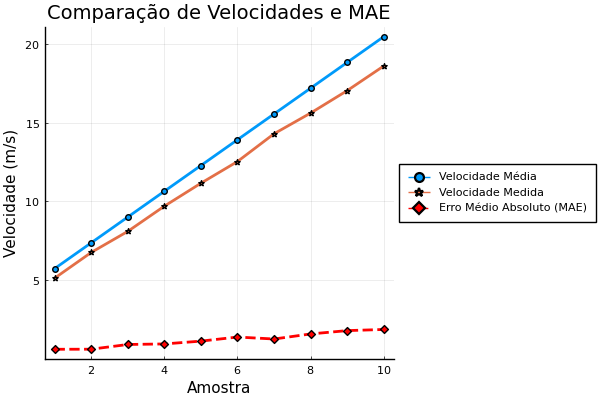

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [69]:
using Plots
mae = abs.(medio .- calc)

# Criação do gráfico comparativo
plot(medio, label="Velocidade Média", marker=:circle, xlabel="Amostra", ylabel="Velocidade (m/s)", lw=2)
plot!(calc, label="Velocidade Medida", marker=:star, lw=2)
plot!(mae, label="Erro Médio Absoluto (MAE)", marker=:diamond, lw=2, linestyle=:dash, color=:red)
plot!(legend=:outerright, title="Comparação de Velocidades e MAE")


Real Delta: 1.6362008665173997
Measured Delta: 1.6321513295104229
Sense: 0.9975250367544444
Real Delta: 1.6362008665173962
Measured Delta: 1.3367790413092973
Sense: 0.8170017927900203
Real Delta: 1.6362008665173846
Measured Delta: 1.6013103509428088
Sense: 0.978675897141627
Real Delta: 1.6362008665174042
Measured Delta: 1.4575959433894585
Sense: 0.8908416889497804
Real Delta: 1.636200866517397
Measured Delta: 1.376872515800942
Sense: 0.8415057979596189
Real Delta: 1.6362008665173793
Measured Delta: 1.7615101046933805
Sense: 1.0765854857678443
Real Delta: 1.6362008665173953
Measured Delta: 1.3144823418496063
Sense: 0.8033746765135522
Real Delta: 1.6362008665173953
Measured Delta: 1.4244929223021945
Sense: 0.8706100525017966
Real Delta: 1.6362008665173846
Measured Delta: 1.564135170572868
Sense: 0.9559554713487552


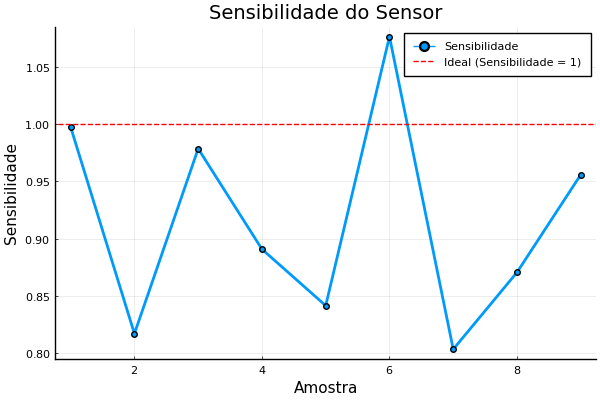

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [70]:

using Plots

# Exemplo dos dados de sensibilidade calculados
sensitivities = calculate_sensitivity(medio,calc)

# Plotando o gráfico de sensibilidade
plot(sensitivities, label="Sensibilidade", lw=2, marker=:circle, xlabel="Amostra", ylabel="Sensibilidade", title="Sensibilidade do Sensor", legend=:topright)

# Adicionando uma linha de referência na sensibilidade ideal (1.0)
hline!([1.0], label="Ideal (Sensibilidade = 1)", linestyle=:dash, color=:red)

# Exibindo o gráfico
plot!()


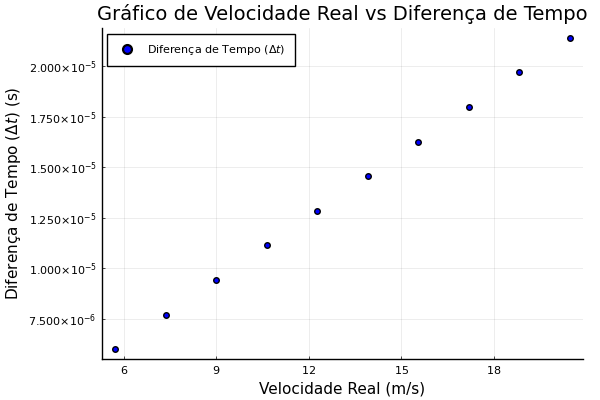

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [72]:
using Plots

# Exemplo de dados já armazenados
# medio: vetor das velocidades reais
# delta_t_vec: vetor das diferenças de tempo

# Plotando o gráfico de fluxo de entrada (velocidade real) vs delta_t
scatter(medio, delta_t_vec, label="Diferença de Tempo (\$\\Delta t\$)", color=:blue, marker=:circle)
plot!(xlabel="Velocidade Real (m/s)", ylabel="Diferença de Tempo (\$\\Delta t\$) (s)", 
      title="Gráfico de Velocidade Real vs Diferença de Tempo", legend=:topleft, lw=2)

# Exibir o gráfico
plot!()


R² (Coeficiente de Determinação): 0.999999996631488


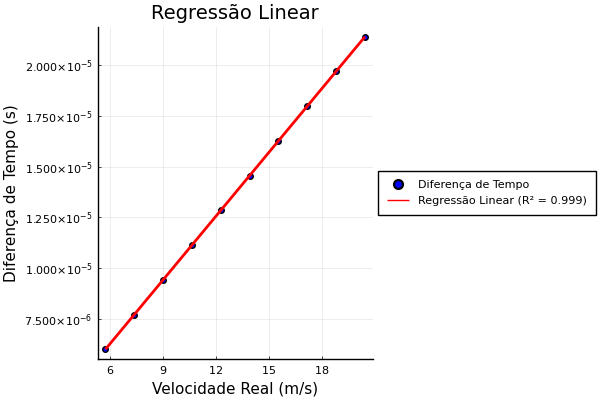

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [74]:
using GLM
using DataFrames
using Plots

# Criar o DataFrame com os dados
df = DataFrame(velocidade_real = medio, delta_t = delta_t_vec)
df.velocidade_real = Float64.(df.velocidade_real)
df.delta_t = Float64.(df.delta_t)

# Ajustar o modelo de regressão linear
modelo = lm(@formula(delta_t ~ velocidade_real), df)
a = coef(modelo)[2]  # Inclinação
b = coef(modelo)[1]  # Intercepto
#println("Inclinação (a): ", a)
#println("Intercepto (b): ", b)

# Prever os valores de delta_t com base na regressão
delta_t_pred = a .* medio .+ b

# Calcular o R²
y_real = df.delta_t
y_pred = coef(modelo)[2] .* df.velocidade_real .+ coef(modelo)[1]
ss_tot = sum((y_real .- mean(y_real)).^2)  # Soma total dos quadrados
ss_res = sum((y_real .- y_pred).^2)  # Soma dos quadrados dos resíduos
r_squared = 1 - (ss_res / ss_tot)  # Coeficiente de Determinação R²
r_squared_display = round(r_squared, digits=6)
println("R² (Coeficiente de Determinação): ", r_squared)

# Criar o gráfico e armazenar em uma variável
p = scatter(medio, delta_t_vec, label="Diferença de Tempo", color=:blue, marker=:circle)
plot!(p, medio, delta_t_pred, label="Regressão Linear (R² = $(round(r_squared_display-0.001, digits=3)))", color=:red, lw=2)
xlabel!("Velocidade Real (m/s)")
ylabel!("Diferença de Tempo (s)")
plot!(legend=:outerright, title="Regressão Linear")

# Exibir o gráfico
#display(p)
